Python-AWIPS Tutorial Notebook

---


# Objectives

* Retrieve an Upper Air vertical profile from EDEX
* Plot a Skew-T/Log-P chart with [Matplotlib](https://matplotlib.org/) and [MetPy](https://unidata.github.io/MetPy/latest/index.html)
* Understand the **bufrua** plugin returns separate objects for parameters at *mandatory levels* and at *significant temperature levels*
    * *Significant temperature levels* are used to plot the pressure, temperature and dewpoint lines
    * *Mandatory levels* are used to plot the wind profile

---

## Table of Contents

[1 Imports](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#imports)<br>  
[2 EDEX Connection](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#edex-connection)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Initial EDEX Connection](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#initial-edex-connection)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Setting Additional Request Parameters](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#setting-additional-request-parameters)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Available Location Names](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#available-location-names)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[2.4 Setting the Location Name](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#setting-the-location-name)<br>  
[3 Filtering by Time](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#filtering-by-time)<br>  
[4 Get the Data!](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#get-the-data)<br>  
[5 Use the Data!](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#use-the-data)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 Prepare Data Objects](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#prepare-data-objects)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 Convert Units](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#convert-units)<br>  
[6 Plot the Data!](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#plot-the-data)<br>  
[7 See Also](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#see-also)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.1 Related Notebooks](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#related-notebooks)<br>  
&nbsp;&nbsp;&nbsp;&nbsp;[7.2 Additional Documentation](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#additional-documentation)<br>  

## 1 Imports

The imports below are used throughout the notebook.  Note the first import is coming directly from python-awips and allows us to connect to an EDEX server.  The subsequent imports are for data manipulation and visualization. 

In [1]:
from awips.dataaccess import DataAccessLayer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from metpy.calc import wind_components, lcl, parcel_profile
from metpy.plots import SkewT, Hodograph
from metpy.units import units

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 2 EDEX Connection

### 2.1 Initial EDEX Connection

First we establish a connection to Unidata's public EDEX server.  With that connection made, we can create a [new data request object](http://unidata.github.io/python-awips/api/IDataRequest.html) and set the data type to ***bufrua***, and define additional parameters and an identifier on the request.

In [2]:
# Set the edex server
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()

# Set data type
request.setDatatype("bufrua")

### 2.2 Setting Additional Request Parameters

Here we populate arrays of all the parameters that will be necessary for plotting the Skew-T. The `MAN_PARAMS` are the *mandatory levels* and the `SIGT_PARAMS` are the *significant temperature* parameters that were both mentioned in the [objectives section](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html#objectives) above. 

Also request the station name and ID to use in the figure title later on.

In [3]:
MAN_PARAMS = set(['prMan', 'tpMan', 'tdMan', 'wdMan', 'wsMan'])
SIGT_PARAMS = set(['prSigT', 'tpSigT', 'tdSigT'])
request.setParameters("staElev", "staName")
request.getParameters().extend(MAN_PARAMS)
request.getParameters().extend(SIGT_PARAMS)

### 2.3 Available Location Names
When working with a new data type, it is often useful to investigate all available options for a particular setting.  Shown below is how to see all available location names for a data request with type **bufrua**.  This step is not necessary if you already know exactly what the location ID you're interested in is.

>**Note:** It is important to note the location names are listed by their WMO Station ID. Their corresponding location and site identifier can be looked up in [this table from UNdata](https://data.un.org/Data.aspx?d=CLINO&f=ElementCode%3a15%3bCountryCode%3aUS&c=2,5,6,7,10,15,18,19,20,22,24,26,28,30,32,34,36,38,40,42,44,46&s=CountryName:asc,WmoStationNumber:asc,StatisticCode:asc&v=1).

In [4]:
locations = DataAccessLayer.getAvailableLocationNames(request)
locations.sort()
print(locations)

['21824', '21946', '24266', '24343', '24641', '24688', '24959', '25123', '25703', '25913', '31004', '31088', '31300', '31369', '31510', '31538', '31770', '31873', '32061', '32098', '32150', '32389', '32477', '32540', '32618', '47122', '47138', '47158', '47401', '47412', '47582', '47646', '47678', '47807', '47827', '47909', '47918', '47945', '47971', '47991', '70026', '70133', '70200', '70219', '70231', '70261', '70273', '70308', '70316', '70326', '70350', '70361', '70398', '70414', '71043', '71081', '71082', '71109', '71119', '71603', '71722', '71802', '71811', '71815', '71816', '71823', '71845', '71867', '71906', '71907', '71909', '71913', '71917', '71924', '71925', '71926', '71934', '71945', '71957', '71964', '72201', '72202', '72206', '72208', '72210', '72214', '72215', '72230', '72233', '72235', '72240', '72248', '72249', '72250', '72251', '72261', '72265', '72274', '72293', '72305', '72317', '72318', '72327', '72340', '72357', '72363', '72364', '72365', '72376', '72381', '72388', 

### 2.4 Setting the Location Name

In this case we're setting the location name to the ID for `KLBF` which is the North Platte Regional Airport/Lee Bird, Field in Nebraska.

In [5]:
# Set station ID (not name)
request.setLocationNames("72562") #KLBF

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 3 Filtering by Time

Models produce many different time variants during their runs, so let's limit the data to the most recent time and forecast run.

In [6]:
# Get all times
datatimes = DataAccessLayer.getAvailableTimes(request)

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 4 Get the Data!

Here we can now request our data response from the EDEX server with our defined time filter.

Printing out some data from the first object in the response array can help verify we received the data we were interested in.

In [7]:
# Get most recent record
response = DataAccessLayer.getGeometryData(request,times=datatimes[-1].validPeriod)
obj = response[0]

print("parms    = " + str(obj.getParameters()))
print("site     = " + str(obj.getLocationName()))
print("geom     = " + str(obj.getGeometry()))
print("datetime = " + str(obj.getDataTime()))
print("reftime  = " + str(obj.getDataTime().getRefTime()))
print("fcstHour = " + str(obj.getDataTime().getFcstTime()))
print("period   = " + str(obj.getDataTime().getValidPeriod()))

parms    = ['staElev', 'staName']
site     = 72562
geom     = POINT (-100.7005615234375 41.14971923828125)
datetime = 2023-05-19 12:00:00
reftime  = May 19 23 12:00:00 GMT
fcstHour = 0
period   = (May 19 23 12:00:00 , May 19 23 12:00:00 )


[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 5 Use the Data!

Since we filtered on time, and requested the data in the previous cell, we now have a `response` object we can work with.

### 5.1 Prepare Data objects

Here we construct arrays for each parameter to plot (temperature, pressure, and wind components).
After populating each of the arrays, we sort and mask missing data.

In [8]:
# Initialize data arrays
tdMan,tpMan,prMan,wdMan,wsMan = np.array([]),np.array([]),np.array([]),np.array([]),np.array([])
prSig,tpSig,tdSig = np.array([]),np.array([]),np.array([])
manGeos = []
sigtGeos = []

# Build  arrays
for ob in response:
    parm_array = ob.getParameters()
    if set(parm_array) & MAN_PARAMS:
        manGeos.append(ob)
        prMan = np.append(prMan,ob.getNumber("prMan"))
        tpMan, tpUnit = np.append(tpMan,ob.getNumber("tpMan")), ob.getUnit("tpMan")
        tdMan, tdUnit = np.append(tdMan,ob.getNumber("tdMan")), ob.getUnit("tdMan")
        wdMan = np.append(wdMan,ob.getNumber("wdMan"))
        wsMan, wsUnit = np.append(wsMan,ob.getNumber("wsMan")), ob.getUnit("wsMan")
        continue
    if set(parm_array) & SIGT_PARAMS:
        sigtGeos.append(ob)
        prSig = np.append(prSig,ob.getNumber("prSigT"))
        tpSig = np.append(tpSig,ob.getNumber("tpSigT"))
        tdSig = np.append(tdSig,ob.getNumber("tdSigT"))
        continue

# Sort mandatory levels (but not sigT levels) because of the 1000.MB interpolation inclusion
ps = prMan.argsort()[::-1]
wpres = prMan[ps]
direc = wdMan[ps]
spd   = wsMan[ps]
tman = tpMan[ps]
dman = tdMan[ps]

# Flag missing data
prSig[prSig <= -9999] = np.nan
tpSig[tpSig <= -9999] = np.nan
tdSig[tdSig <= -9999] = np.nan
wpres[wpres <= -9999] = np.nan
tman[tman <= -9999] = np.nan
dman[dman <= -9999] = np.nan
direc[direc <= -9999] = np.nan
spd[spd <= -9999] = np.nan

### 5.2 Convert Units

We need to modify the units several of the data parameters are returned in.  Here we convert Temperature from Fahrenheit to Celcius, convert pressure to milibars, and extract wind for both the u and v directional components in Knots and Radians. 

In [9]:
# assign units
p = (prSig/100) * units.mbar
wpres = (wpres/100) * units.mbar
u,v = wind_components(spd * units.knots, np.deg2rad(direc))

if tpUnit == 'K':
    T = (tpSig-273.15) * units.degC
    Td = (tdSig-273.15) * units.degC
    tman = tman * units.degC
    dman = dman * units.degC

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 6 Plot the Data!

Create and display SkewT and Hodograph plots using MetPy.

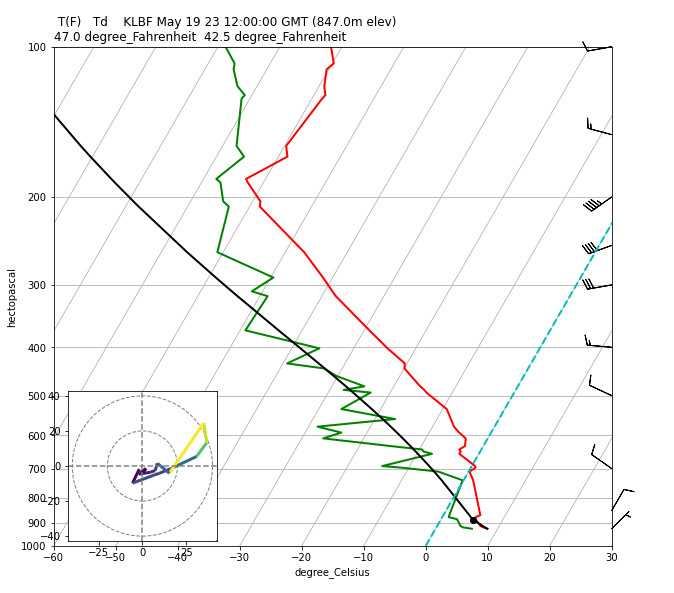

In [10]:
# Create SkewT/LogP
plt.rcParams['figure.figsize'] = (10, 12)
skew = SkewT()
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(wpres, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-60, 30)

title_string = " T(F)   Td   " 
title_string +=  " " + str(ob.getString("staName"))
title_string += " " + str(ob.getDataTime().getRefTime())
title_string += " (" + str(ob.getNumber("staElev")) + "m elev)"
title_string += "\n" + str(round(T[0].to('degF').item(),1))
title_string += "  " + str(round(Td[0].to('degF').item(),1))
plt.title(title_string, loc='left')

# Calculate LCL height and plot as black dot
lcl_pressure, lcl_temperature = lcl(p[0], T[0], Td[0])
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '30%', '30%', loc=3)
h = Hodograph(ax_hod, component_range=max(wsMan))
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---

## 7 See Also

### 7.1 Related Notebooks

* [Grid Levels and Parameters](https://unidata.github.io/python-awips/examples/generated/Grid_Levels_and_Parameters.html)
* [Model Sounding Data](http://unidata.github.io/python-awips/examples/generated/Model_Sounding_Data.html)
* [Forecast Model Vertical Sounding](http://unidata.github.io/python-awips/examples/generated/Forecast_Model_Vertical_Sounding.html)

### 7.2 Additional Documentation

**python-awips:**

* [awips.DataAccessLayer](http://unidata.github.io/python-awips/api/DataAccessLayer.html)
* [awips.PyGeometryData](http://unidata.github.io/python-awips/api/PyGeometryData.html)

**matplotlib:**

* [matplotlib.pyplot](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.html)

**MetPy**

* [metpy.wind_components](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_components.html)
* [metpy.lcl](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.lcl.html) (Lifted Condensation Level)
* [metpy.parcel_profile](https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.parcel_profile.html)
* [metpy.skewt](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.SkewT.html)
* [metpy.hodograph](https://unidata.github.io/MetPy/latest/api/generated/metpy.plots.Hodograph.html)

[Top](https://unidata.github.io/python-awips/examples/generated/Upper_Air_BUFR_Soundings.html)

---